In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [9]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):

    # drop non-english words
    words = set(nltk.corpus.words.words())
    " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [10]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, text, min_length):
         # drop non-english words
        words = set(nltk.corpus.words.words())
        " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(text) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        if len(wordnet_tagged) <= min_length:
            return ''
        else:
             # rejoins lemmatized sentence 
            text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
            return text_norm

# IMPORT

In [11]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df.head()

,Title,Userscore,Comment
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it..."
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...


In [12]:
df.shape

(260269, 3)

In [13]:
df_sub = df.sample(n=2000, random_state=2333)

In [14]:
df_sub.Userscore.value_counts(normalize=True).sort_index()

1.0     0.0295
2.0     0.0210
3.0     0.0265
4.0     0.0350
5.0     0.0355
6.0     0.0560
7.0     0.0695
8.0     0.1090
9.0     0.2045
10.0    0.4135
Name: Userscore, dtype: float64

In [15]:
import pickle

transformed_tr = pickle.load(open('processed_df/transformed_tr_2k.pkl','rb'))
transformed_te = pickle.load(open('processed_df/transformed_te_2k.pkl','rb'))

# Train test split

In [16]:
X = df_sub['Comment']
y = df_sub['Userscore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [24]:
# df['Comment'] = df['Comment'].apply(process_text, min_length = 10)

transformed_tr = X_train.apply(process_text, min_length = 10)

# took 2m30s

In [25]:
transformed_te = X_test.apply(process_text, min_length = 10)

# took 1m5s

# NB

- baseline

In [28]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('multinb', MultinomialNB())]
NB_pipeline = Pipeline(steps)

In [29]:
NB_pipeline.fit(transformed_tr, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [31]:
y_pred = NB_pipeline.predict(transformed_te)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        15
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00        21
         5.0       0.00      0.00      0.00        23
         6.0       0.00      0.00      0.00        36
         7.0       0.00      0.00      0.00        43
         8.0       0.00      0.00      0.00        70
         9.0       0.20      0.02      0.03       114
        10.0       0.42      1.00      0.59       246

    accuracy                           0.41       600
   macro avg       0.06      0.10      0.06       600
weighted avg       0.21      0.41      0.25       600



c:\Users\qwswe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


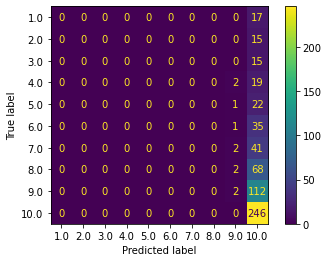

In [42]:
plot_confusion_matrix(NB_pipeline, transformed_te, y_test)

# Random Forest

- baseline

In [22]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('random forest', RandomForestClassifier())]
rf_pipeline = Pipeline(steps)

In [23]:
rf_pipeline.fit(transformed_tr, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('random forest', RandomForestClassifier())])

In [24]:
y_pred = rf_pipeline.predict(transformed_te)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        11
         4.0       0.00      0.00      0.00        23
         5.0       0.00      0.00      0.00        24
         6.0       0.00      0.00      0.00        33
         7.0       0.00      0.00      0.00        46
         8.0       0.00      0.00      0.00        66
         9.0       0.13      0.09      0.11       103
        10.0       0.42      0.85      0.56       262

    accuracy                           0.38       600
   macro avg       0.06      0.09      0.07       600
weighted avg       0.21      0.39      0.26       600



c:\Users\qwswe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


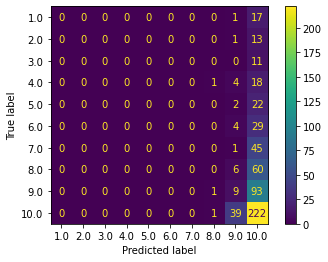

In [26]:
plot_confusion_matrix(rf_pipeline, transformed_te, y_test)

- man tuning

In [ ]:
steps = [('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)), ('random forest', RandomForestClassifier())]
rf_pipeline = Pipeline(steps)

In [ ]:
rf_pipeline.fit(transformed_tr, y_train)

In [ ]:
y_pred = rf_pipeline.predict(transformed_te)

In [ ]:
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf_pipeline, transformed_te, y_test)